# To Reason or Not?

The TRON notebook is a pipeline to generate synthetic data for the To Reason or Not (TRON) Dataset. Reasoning models are token-heavy and compute-heavy. What if we could create an agentic pipeline that leveraged a Reasoning Agent who would quickly determine whether or not the user's query was complex enough to justify a more thorough reasoning task?

![](./images/tron-arch.jpg)

Imagine a case where the underlying model of the TRON-trained agent were to be restricted to a finite token limit to determine and the downstream response generation agents were given a more liberal allocation. The TRON-trained agent could be trained to support an arbitrary number of downstream response agents as well, making the implications of such an agent very beneficial to research fields. 

Further, this architecture shifts the burden of the resource allocation to the agentic model system itself rather than the user. An inexperienced, programmatic, or high-frequency user may not have the time or knowledge to individually assess the proper model type to use, thus exposing themselves to unnessesary token consumption.

The TRON Dataset is a step towards the reality visualized and discribed above and represents a tangible step forward to productive, safe, and user-oriented AI systems. TRON can be used to fine tine a reasoning model to quickly reason through whether or not it makes sense to invest in a full reasoning task or a simple LLM completion task makes more sense.

## Contents

1. [Introduction](#to-reason-or-not)
2. [Configuration](#configuration)
3. [Prompt Engineering](#prompt-engineering)
4. [Helper Functions](#helper-functions)
5. [Sampling](#sampling)
6. [Question Generation Loop](#question-generation-loop)
7. [Output Management](#output-management)
8. [Visualize Dataset](#visualize-dataset)
9. [Reasoning Generation Loop](#reasoning-generation-loop)
10. [Inspect Output Dataset](#inspect-output-dataset)
11. [Upload to Hugging Face Hub](#upload-to-hugging-face-hub)

In [ ]:
# install dependencies
%pip install datasets huggingface_hub matplotlib pandas seaborn scipy transformers together tqdm -qqq

In [48]:
# import dependencies
import csv
import numpy as np
import os
import re
import json
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import random
import time
import pandas as pd
import seaborn as sns
from collections import defaultdict
from collections import deque
from datasets import Dataset
from huggingface_hub import HfApi, HfFolder
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline
from tqdm import tqdm
from transformers import AutoTokenizer
from together import Together

## Configuration

The TRON notebook supports a highly customizable generation configuration to prepare your model to specialize in a specific field or have a broad base of general knowledge.

In order to reduce bias and increase applicability across a broad set of domains, you can customize this pipeline according to the parameters below. All inputs are randomized within the boundaries that you define.

In [30]:
config = {
    # iteration count
    # configure the amount of rows of data to generate
    "num_iterations": 10,

    # model proportion bounds
    # reduce dataset bias by ensuring diverse generation
    # during generation, model is selected randomly
    # define the min / max proportions that any individual model may be polled during generation
    "min_poll": 0.25,
    "max_poll": 0.5,

    # difficulty proportion bounds
    # during generation, question difficulty is selected randomly
    # define the min / max proportions of each difficulty to generate more or less complex datasets
    "min_easy": 0.2,
    "max_easy": 0.4,
    "min_normal": 0.2,
    "max_normal": 0.4,
    "min_hard": 0.2,
    "max_hard": 0.4,

    # category usage bounds
    # during generation, category is selected randomly
    # define the mix / max proportions of each category to generate more or less topical datasets
    "min_cat": 0.075,
    "max_cat": 0.15,

    # define custom categories
    # during generation, categories are selected at random from this defined list
    # increase or decrease the number of categories to increase dataset diversity
    # choose several variants of the same category to target a specific domain
    "allowed_categories": ["geography", "logic", "ancient_history", "calculus", "politics", "pop_culture", "language", "philosophy", "military_sciences", "ethics"],

    # output utils
    # notebook supports export to csv for local use
    "save_to_csv": True,
    "csv_filename": "tron_demo.csv",

    # reasoning configuration
    # modify the reasoning loop for your use case
    "reasoning_model": "deepseek-ai/DeepSeek-R1",
    "max_tokens": 500,
    "max_queries_per_minute": 3,
    "rate_limit_window_seconds": 60
}

# available models: https://www.together.ai/inference
models = [
    "meta-llama/Llama-4-Scout-17B-16E-Instruct",
    "deepseek-ai/DeepSeek-V3",
    "google/gemma-2-27b-it",
    "microsoft/WizardLM-2-8x22B"
]

## Prompt Engineering

The default prompt supports the injection of `difficulty` and `category` parameters to focus generation on the target domains. The default query here has proven to work well for the task of generating predictable and structured output, but you may wish to update it according to your use case.

In [31]:
# function to control 
def get_sample_within_bounds(counts, options, min_prop, max_prop, total):
    eligible = []
    min_count = int(total * min_prop)
    max_count = int(total * max_prop)

    for option in options:
        count = counts[option]
        if count < max_count:
            eligible.append(option)

    return random.choice(eligible) if eligible else None

# function contain question generation prompt
# modify this prompt to address your specific use case if desired
def inject_prompt(difficulty, category):
    return f"""
You are generating synthetic data for evaluating language models.

Your task is to generate ONE creative and diverse question that could be used to evaluate a language model.
Avoid repetition and be imaginative — use a wide variety of topics and question formats.

The question should be about **{category}** and of **{difficulty}** difficulty.

In addition to the question, also indicate:
1. Whether it requires reasoning (e.g., logical steps, inference).
2. A one-word category (e.g., geography, logic, history, math, language, etc.).
3. A one-word difficulty level (easy, normal, or hard).

Respond ONLY with a valid JSON object, and do NOT include any explanation or markdown formatting.
Do NOT wrap your response in a ```json code block``` — return only raw JSON.

Format:
{{
  "question": "What is the capital of France?",
  "use_reasoning": false,
  "category": "geography",
  "difficulty": "easy"
}}
"""


## Helper Functions

These functions are used by the main algorithm to support parameters defined in the [Configuration](#configuration) and extract structured output from the models. In order to use this pipeline out of the box, it is recommended not to modify these functions unless you wish to modify overall notebook behavior (which is welcomed and encouraged).

In [32]:
# function to control amount of time each model is polled
def get_sample_within_bounds(counts, options, min_prop, max_prop, total):
    eligible = []
    min_count = int(total * min_prop)
    max_count = int(total * max_prop)

    for option in options:
        count = counts[option]
        if count < max_count:
            eligible.append(option)

    return random.choice(eligible) if eligible else None

# function to extract structure json content from llm responses
def extract_json_block(text):
    """
    Extracts the first valid JSON object from a string using regex.
    """
    cleaned = re.sub(r"^```json|```$", "", text.strip(), flags=re.IGNORECASE).strip()
    match = re.search(r"\{[\s\S]*?\}", cleaned)
    if not match:
        return None
    try:
        return json.loads(match.group(0))
    except json.JSONDecodeError:
        return None


### Sampling



In [33]:
# sampling functions which respect the user-defined parameters in the config
def get_model_sample(model_counts, total_iterations):
    return get_sample_within_bounds(
        counts=model_counts,
        options=models,
        min_prop=config["min_poll"],
        max_prop=config["max_poll"],
        total=total_iterations
    )

def get_difficulty_sample(difficulty_counts, total_iterations):
    options = ["easy", "normal", "hard"]
    bounds = {
        "easy": (config["min_easy"], config["max_easy"]),
        "normal": (config["min_normal"], config["max_normal"]),
        "hard": (config["min_hard"], config["max_hard"]),
    }

    eligible = [
        d for d in options
        if difficulty_counts[d] < int(total_iterations * bounds[d][1])
    ]
    return random.choice(eligible) if eligible else None

def get_category_sample(category_counts, total_iterations):
    return get_sample_within_bounds(
        counts=category_counts,
        options=config["allowed_categories"],
        min_prop=config["min_cat"],
        max_prop=config["max_cat"],
        total=total_iterations
    )


# Question Generation Loop

In [34]:
from dotenv import load_dotenv
load_dotenv() 
api_key = os.getenv("TOGETHER_API_KEY")

In [35]:
# main generation loop for 
client = Together(api_key=api_key)
results = []

model_counts = defaultdict(int)
difficulty_counts = defaultdict(int)
category_counts = defaultdict(int)

print(f"\n🔁 Generating {config['num_iterations']} samples...")

for i in tqdm(range(config["num_iterations"])):
    model = get_model_sample(model_counts, config["num_iterations"])
    difficulty = get_difficulty_sample(difficulty_counts, config["num_iterations"])
    category = get_category_sample(category_counts, config["num_iterations"])

    if not all([model, difficulty, category]):
        print(f"⚠️ Skipping iteration {i} — no valid model or category/difficulty available.")
        continue

    prompt = inject_prompt(difficulty, category)

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}]
        )
        reply = response.choices[0].message.content.strip()
        data = extract_json_block(reply)

        if not data or not all(k in data for k in ["question", "use_reasoning", "category", "difficulty"]):
            raise ValueError("Response missing required fields.")

        results.append({
            "model": model,
            "question": data["question"],
            "use_reasoning": data["use_reasoning"],
            "category": data["category"],
            "difficulty": data["difficulty"]
        })

        model_counts[model] += 1
        difficulty_counts[difficulty] += 1
        category_counts[category] += 1

    except Exception as e:
        print(f"\n❌ Error with model '{model}': {e}")
        print(f"⚠️ Raw reply: {reply if 'reply' in locals() else 'N/A'}")



🔁 Generating 10 samples...


100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


## Output Management

In the [Configuration](#configuration), you can set `save_to_csv` to `True` if you'd like to save a local copy of the generated dataset. Otherwise, the generated dataset is stored in-mem as a DataFrame for use during [Reasoning Generation Loop](#reasoning-generation-loop).

In [36]:
df = pd.DataFrame(results)

print("\n📊 Final Counts:")
print("Models:", dict(model_counts))
print("Difficulties:", dict(difficulty_counts))
print("Categories:", dict(category_counts))

if config["save_to_csv"] and not df.empty:
    df.to_csv(config["csv_filename"], index=False)
    print(f"\n📁 Results saved to: {config['csv_filename']}")
elif config["save_to_csv"]:
    print("\n⚠️ No results to save — CSV not written.")



📊 Final Counts:
Models: {'meta-llama/Llama-4-Scout-17B-16E-Instruct': 5, 'deepseek-ai/DeepSeek-V3': 2, 'google/gemma-2-27b-it': 1, 'microsoft/WizardLM-2-8x22B': 2}
Difficulties: {'easy': 4, 'normal': 4, 'hard': 2}
Categories: {'geography': 1, 'logic': 1, 'ancient_history': 1, 'calculus': 1, 'politics': 1, 'pop_culture': 1, 'language': 1, 'philosophy': 1, 'military_sciences': 1, 'ethics': 1}

📁 Results saved to: tron_demo.csv


## Visualize Dataset

You can use the visualizations commands below out of the box to get a simple report of the output of your generation pipeline.

The following information is visualized:
1. Count of Category, stacked segments of difficulty.
2. Proportion of `use_reasoning` values.
3. Count of number of times each model was polled.



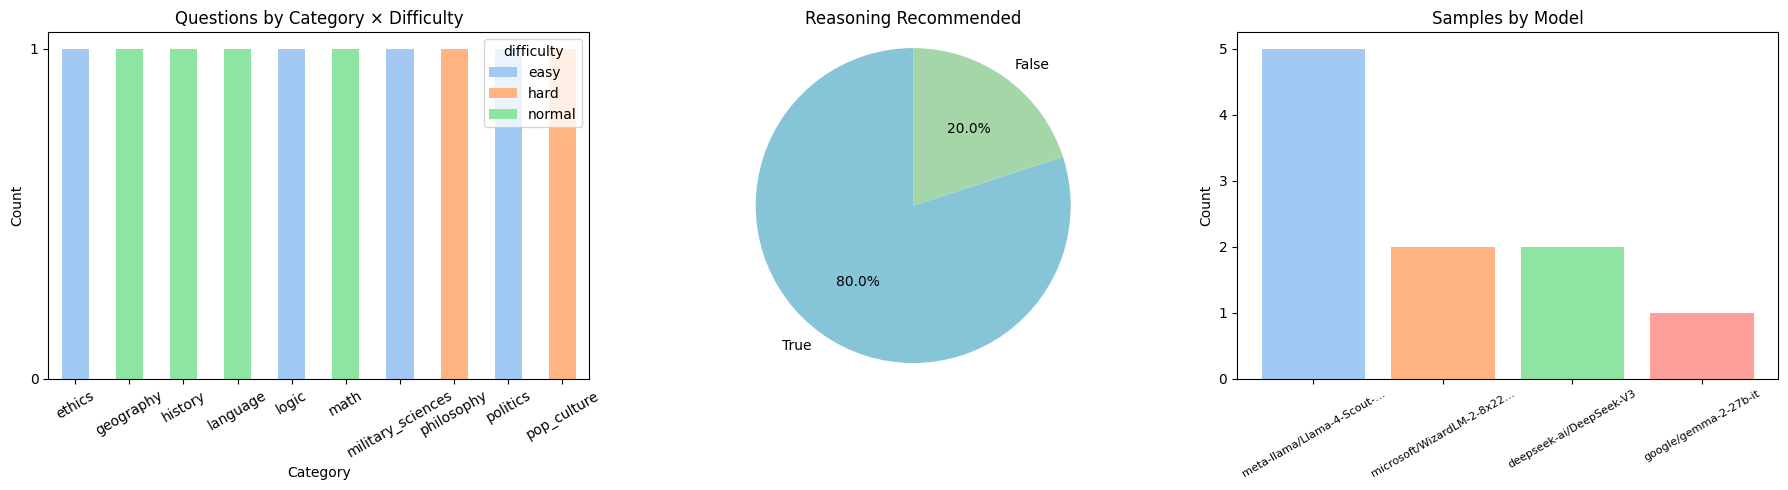

In [37]:
# set color theme
plt.style.use("seaborn-v0_8-pastel")

# dashboarding format
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# count of category stacked by difficulty
pivot = df.pivot_table(index="category", columns="difficulty", aggfunc="size", fill_value=0)
pivot.plot(
    kind="bar",
    stacked=True,
    ax=axes[0],
    color=sns.color_palette("pastel", n_colors=len(pivot.columns))
)
axes[0].set_title("Questions by Category × Difficulty")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', labelrotation=30)
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # ✅ Only integer ticks

# proportion of use_reasoning values
reasoning_colors = {
    True: "#86c5d8",   # pastel blue
    False: "#a5d6a7"   # pastel green
}
reasoning_counts = df["use_reasoning"].value_counts()
axes[1].pie(
    reasoning_counts,
    labels=["True", "False"],
    autopct='%1.1f%%',
    colors=[reasoning_colors.get(k) for k in reasoning_counts.index],
    startangle=90
)
axes[1].set_title("Reasoning Recommended")
axes[1].axis('equal')

# model usage bar chart
model_counts = df["model"].value_counts()
truncated_labels = [m[:25] + "…" if len(m) > 25 else m for m in model_counts.index]
bar_colors = sns.color_palette("pastel", n_colors=len(model_counts))

axes[2].bar(truncated_labels, model_counts.values, color=bar_colors)
axes[2].set_title("Samples by Model")
axes[2].set_ylabel("Count")
axes[2].tick_params(axis='x', labelrotation=30, labelsize=8)
axes[2].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# display charts
plt.tight_layout()
plt.show()


## Reasoning Generation Loop

This loop iterates through each line of the output dataframe from [Question Generation Loop](#question-generation-loop) and polls [DeepSeek-R1](https://huggingface.co/deepseek-ai/DeepSeek-R1) to generate a `<think>` block (representing the reasoning-only segment of an answer) with fewer than 128 tokens. The `max_tokens` parameter is configurable and injected into the query sent to the model itself to ensure that the the limit is communicated literally as well as programatically, this has been observed to geenerate few incomplete or cut-off responses.

In [ ]:
# Use a tokenizer for token counting (adjust as needed)
tokenizer = AutoTokenizer.from_pretrained("gpt2")  # Use gpt2 tokenizer as default

reasoning_strings = []
request_timestamps = deque()

print(f"\n🤔 Generating reasoning strings with {config['reasoning_model']}...\n")

max_tokens = config["max_tokens"]
max_qpm = config["max_queries_per_minute"]
window_seconds = config["rate_limit_window_seconds"]
reasoning_model = config["reasoning_model"]

token_lengths = []
token_limit_hits = []
error_count = 0
start_time = time.time()

for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Reasoning via {reasoning_model}"):
    question = row["question"]
    label = row["use_reasoning"]
    category = row["category"]
    label_str = "does" if label else "does not"

    prompt = f"""
<think>
You are a minimal reasoning agent tasked with quickly evaluating whether a question requires multi-step logical reasoning or not.

The following question {label_str} require reasoning.
Category: {category}

Question: {question}

Briefly explain why this is the case. 
⚠️ You must be concise. Your response must not exceed {max_tokens} tokens.
Excessively long or elaborate explanations will be discarded.
</think>
""".strip()

    # Rate-limiting logic
    now = time.time()
    request_timestamps.append(now)
    while len(request_timestamps) > max_qpm:
        if now - request_timestamps[0] < window_seconds:
            sleep_time = window_seconds - (now - request_timestamps[0])
            print(f"⏳ Rate limit hit — sleeping {sleep_time:.1f}s...")
            time.sleep(sleep_time)
        else:
            request_timestamps.popleft()

    try:
        response = client.chat.completions.create(
            model=reasoning_model,
            messages=[{"role": "user", "content": prompt}],
            stop=["</think>"],
            max_tokens=max_tokens
        )
        response_text = response.choices[0].message.content.strip()
        full_reasoning = response_text.replace("\n", " ").replace("\r", " ").strip()
        reasoning_strings.append(full_reasoning)

        # ✅ Real token length
        token_count = len(tokenizer.encode(response_text))
        token_lengths.append(token_count)
        token_limit_hits.append(token_count >= max_tokens)

    except Exception as e:
        error_count += 1
        print(f"⚠️ Error on question: {question[:60]}... → {e}")
        print("⏱️ Retrying after 60 seconds...")
        time.sleep(60)
        try:
            response = client.chat.completions.create(
                model=reasoning_model,
                messages=[{"role": "user", "content": prompt}],
                stop=["</think>"],
                max_tokens=max_tokens
            )
            response_text = response.choices[0].message.content.strip()
            full_reasoning = response_text.replace("\n", " ").replace("\r", " ").strip() + " </think>"
            reasoning_strings.append(full_reasoning)

            token_count = len(tokenizer.encode(response_text))
            token_lengths.append(token_count)
            token_limit_hits.append(token_count >= max_tokens)

        except Exception as e2:
            error_count += 1
            print(f"❌ Retry failed → {e2}")
            reasoning_strings.append("<think>Error generating reasoning</think>")
            token_lengths.append(0)
            token_limit_hits.append(False)

# Update the DataFrame in memory
df["reasoning"] = reasoning_strings
end_time = time.time()


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


🤔 Generating reasoning strings with deepseek-ai/DeepSeek-R1...



Reasoning via deepseek-ai/DeepSeek-R1:  10%|█         | 1/10 [00:05<00:49,  5.45s/it]

⚠️ Error on question: Given the function f(x) = (2x^3 - 5x^2 + x - 2)/(x^2 - 4), f... → Error code: 429 - {"message": "You are on tier Build Tier 1, which offers 3 queries and 180000 tokens per minute for this model. Please upgrade to higher tier for higher rate limit at https://api.together.xyz/settings/billing.", "type_": "model_rate_limit"}
⏱️ Retrying after 60 seconds...


Reasoning via deepseek-ai/DeepSeek-R1:  20%|██        | 2/10 [01:35<07:22, 55.33s/it]

⚠️ Error on question: If you travel due east from the Eiffel Tower, what major mou... → Error code: 429 - {"message": "You are on tier Build Tier 1, which offers 3 queries and 180000 tokens per minute for this model. Please upgrade to higher tier for higher rate limit at https://api.together.xyz/settings/billing.", "type_": "model_rate_limit"}
⏱️ Retrying after 60 seconds...


Reasoning via deepseek-ai/DeepSeek-R1:  30%|███       | 3/10 [03:04<08:14, 70.64s/it]

⚠️ Error on question: What 1994 movie starring Tom Hanks and Meg Ryan was inspired... → Error code: 429 - {"message": "You are on tier Build Tier 1, which offers 3 queries and 180000 tokens per minute for this model. Please upgrade to higher tier for higher rate limit at https://api.together.xyz/settings/billing.", "type_": "model_rate_limit"}
⏱️ Retrying after 60 seconds...


Reasoning via deepseek-ai/DeepSeek-R1:  40%|████      | 4/10 [04:34<07:49, 78.18s/it]

⚠️ Error on question: What is the primary function of a military reconnaissance un... → Error code: 429 - {"message": "You are on tier Build Tier 1, which offers 3 queries and 180000 tokens per minute for this model. Please upgrade to higher tier for higher rate limit at https://api.together.xyz/settings/billing.", "type_": "model_rate_limit"}
⏱️ Retrying after 60 seconds...


Reasoning via deepseek-ai/DeepSeek-R1:  60%|██████    | 6/10 [06:42<04:31, 67.83s/it]

⚠️ Error on question: If all Bloops are Razzies and all Razzies are Lazzies, are a... → Error code: 429 - {"message": "You are on tier Build Tier 1, which offers 3 queries and 180000 tokens per minute for this model. Please upgrade to higher tier for higher rate limit at https://api.together.xyz/settings/billing.", "type_": "model_rate_limit"}
⏱️ Retrying after 60 seconds...


Reasoning via deepseek-ai/DeepSeek-R1:  70%|███████   | 7/10 [08:11<03:44, 74.76s/it]

⚠️ Error on question: Is it possible for a deterministic universe to have free wil... → Error code: 429 - {"message": "You are on tier Build Tier 1, which offers 3 queries and 180000 tokens per minute for this model. Please upgrade to higher tier for higher rate limit at https://api.together.xyz/settings/billing.", "type_": "model_rate_limit"}
⏱️ Retrying after 60 seconds...


Reasoning via deepseek-ai/DeepSeek-R1:  90%|█████████ | 9/10 [10:16<01:04, 64.60s/it]

⚠️ Error on question: Is it okay to tell a white lie to avoid hurting someone's fe... → Error code: 429 - {"message": "You are on tier Build Tier 1, which offers 3 queries and 180000 tokens per minute for this model. Please upgrade to higher tier for higher rate limit at https://api.together.xyz/settings/billing.", "type_": "model_rate_limit"}
⏱️ Retrying after 60 seconds...


Reasoning via deepseek-ai/DeepSeek-R1: 100%|██████████| 10/10 [11:43<00:00, 70.35s/it]


In [39]:
if config.get("save_to_csv", False):
    csv_path = config["csv_filename"]

    if os.path.exists(csv_path):
        try:
            df.to_csv(csv_path, index=False, quoting=csv.QUOTE_ALL)
            print(f"\n✅ Reasoning column appended and saved to existing CSV: {csv_path}")
        except Exception as e:
            print(f"❌ Error saving to CSV: {e}")
    else:
        print(f"\n⚠️ CSV file not found: {csv_path}. No file saved, but reasoning is attached to DataFrame.")
else:
    print("📁 save_to_csv is False — skipping file write, reasoning is only in-memory.")



✅ Reasoning column appended and saved to existing CSV: tron_demo.csv


# Inspect Output Dataset


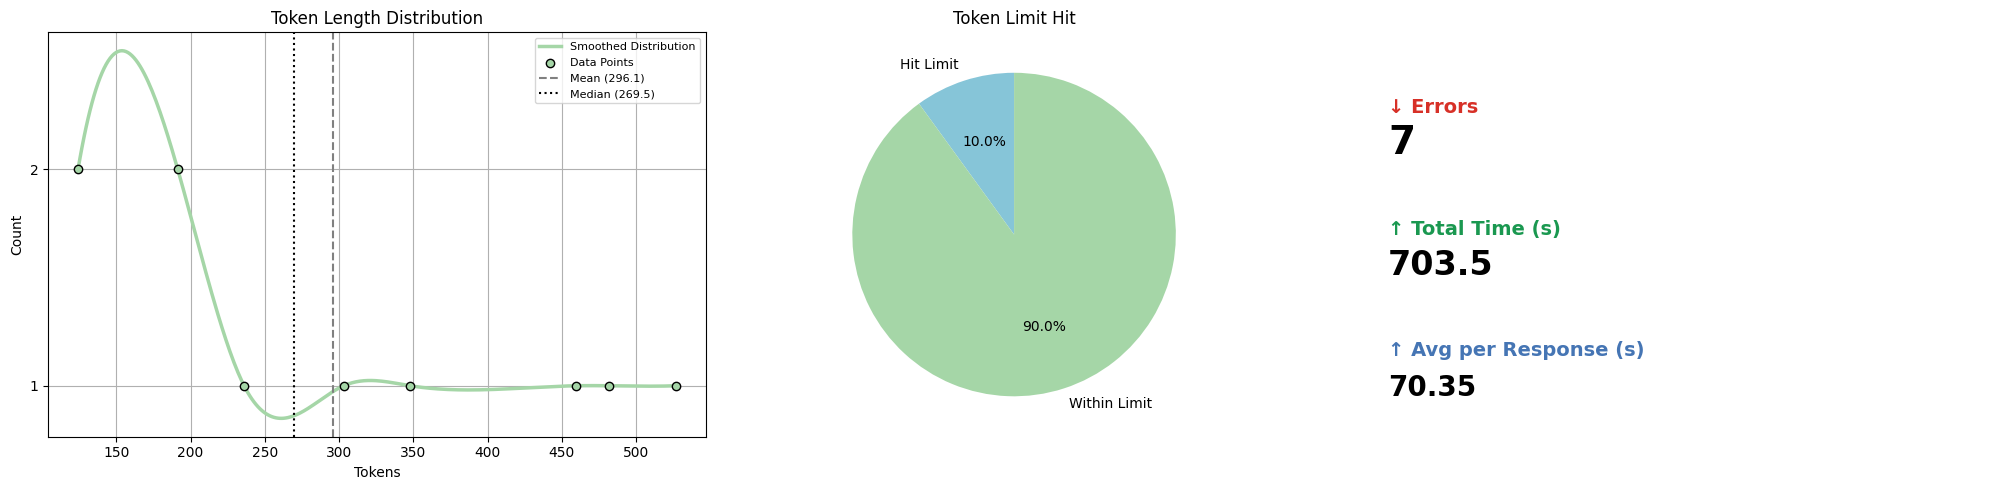

In [47]:
# Set pastel theme
plt.style.use("seaborn-v0_8-pastel")

# Prepare data
bins = np.linspace(min(token_lengths), max(token_lengths), 20)
counts, edges = np.histogram(token_lengths, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

# Remove bins with zero counts for smoother continuous line
centers_nonzero = centers[counts > 0]
counts_nonzero = counts[counts > 0]

# Compute stats
total_time = end_time - start_time
time_per_response = total_time / len(df)
mean_tokens = np.mean(token_lengths)
median_tokens = np.median(token_lengths)

# Layout: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1️⃣ Token Length Distribution (Smoothed)
if len(centers_nonzero) >= 4:
    x_smooth = np.linspace(centers_nonzero.min(), centers_nonzero.max(), 300)
    spline = make_interp_spline(centers_nonzero, counts_nonzero, k=3)
    y_smooth = spline(x_smooth)
    
    axes[0].plot(x_smooth, y_smooth, color="#a5d6a7", linewidth=2.5, label="Smoothed Distribution")
    axes[0].scatter(centers_nonzero, counts_nonzero, color="#a5d6a7", edgecolor="black", zorder=3, label="Data Points")
else:
    axes[0].plot(centers_nonzero, counts_nonzero, color="#a5d6a7", linewidth=2.5, label="Token Lengths")
    axes[0].scatter(centers_nonzero, counts_nonzero, color="#a5d6a7", edgecolor="black", zorder=3)

# Mean and median vertical lines
axes[0].axvline(mean_tokens, color="gray", linestyle="--", linewidth=1.5, label=f"Mean ({mean_tokens:.1f})")
axes[0].axvline(median_tokens, color="black", linestyle=":", linewidth=1.5, label=f"Median ({median_tokens:.1f})")

axes[0].set_title("Token Length Distribution")
axes[0].set_xlabel("Tokens")
axes[0].set_ylabel("Count")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[0].grid(True)
axes[0].legend(fontsize=8)

# 2️⃣ Token Limit Hit Pie Chart
limit_hit_counts = {
    "Hit Limit": sum(token_limit_hits),
    "Within Limit": len(token_limit_hits) - sum(token_limit_hits)
}
axes[1].pie(
    limit_hit_counts.values(),
    labels=limit_hit_counts.keys(),
    autopct='%1.1f%%',
    colors=["#86c5d8", "#a5d6a7"],
    startangle=90
)
axes[1].set_title("Token Limit Hit")

# 3️⃣ KPI Box: Errors + Time
axes[2].axis("off")
axes[2].text(0.1, 0.8, "↓ Errors", fontsize=14, fontweight="bold", color="#d73027")
axes[2].text(0.1, 0.7, f"{error_count}", fontsize=28, fontweight="bold")

axes[2].text(0.1, 0.5, "↑ Total Time (s)", fontsize=14, fontweight="bold", color="#1a9850")
axes[2].text(0.1, 0.4, f"{total_time:.1f}", fontsize=24, fontweight="bold")

axes[2].text(0.1, 0.2, "↑ Avg per Response (s)", fontsize=14, fontweight="bold", color="#4575b4")
axes[2].text(0.1, 0.1, f"{time_per_response:.2f}", fontsize=20, fontweight="bold")

# Display
plt.tight_layout()
plt.show()


# Upload to Hugging Face Hub

In [50]:
api = HfApi()
api.create_repo(repo_id="ZennyKenny/TRON-dataset-demo", repo_type="dataset", exist_ok=True)
hf_dataset = Dataset.from_pandas(df)
hf_dataset.push_to_hub("ZennyKenny/TRON-dataset-demo")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ZennyKenny/TRON-dataset-demo/commit/20ba7f9a6a16c3c937912bb1a1e1b0a03b1846a5', commit_message='Upload dataset', commit_description='', oid='20ba7f9a6a16c3c937912bb1a1e1b0a03b1846a5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ZennyKenny/TRON-dataset-demo', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ZennyKenny/TRON-dataset-demo'), pr_revision=None, pr_num=None)